С точки зрения концепции выполнения проекта — нам необходимо: продемонстрировать способность грамотно работать с экспериментальными статистическими данными, что включает в себя проверку корректности проведения и интерпретацию результатов построенного A/B-тестирования, правильную формулировку гипотез, выбор подходящих статистических методов, моделей и их параметров, а также построение итоговых выводов из анализа — и исследователей: уметь выбирать релевантный датасет, проводить содержательный EDA, находить закономерности и превращать их в осмысленные статистические гипотезы для проверки.



---
# Часть 1


Датасет состоит из пяти столбцов:

* `user_id` — уникальный идентификатор пользователя;

* `timestamp` — время посещения пользователем страницы;

* `group` — группа эксперимента, к которой был случайно отнесён пользователь:

  *   `control` — контрольная группа,
  *   `treatment` — экспериментальная группа;

* `landing_page` — версия лендинга, которую увидел пользователь:

  *   `old_page` — старая версия страницы,
  *   `new_page` — новая версия страницы;

* `converted` — бинарный признак, показывающий, совершил ли пользователь целевое действие (целевым действием является регистрация на курс).








По замыслу A/B-теста контрольной группе (`control`) должна была показываться старая версия лендинга — `old_page`; экспериментальной группе (`treatment`) должна была показываться новая версия лендинга — `new_page`.

Нам необходимо:
- понять структуру данных, провести EDA и выбрать метрику, с которой будете работать;
- проверить корректность проведения тестирования (посмотреть на однородность групп; задуматься об A/A тесте; не забыть, что в нашем распоряжении есть еще и временные метки);
- сформулировать нулевую и альтернативную гипотезы на основании выбранной метрики;
- выбрать и обосновать статистический тест;
- решить, нужно ли устаналивать значения каких-либо параметров до начала анализа тестирования;
- оценить разницу в результатах и сделать выводы о практической значимости эксперимента;
- сформулировать рекомендации и бизнес-инсайты по результатам эксперимента.






---


In [ ]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import norm
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import gamma, norm, bernoulli
from scipy.stats import binomtest

## Предварительная обработка

### Очистка данных

In [ ]:
df=pd.read_csv("data_ab.csv")
df

,user_id,timestamp,group,landing_page,converted
0,851104,2025-01-21 22:11:48.556739,control,old_page,0
1,804228,2025-01-12 08:01:45.159739,control,old_page,0
2,661590,2025-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2025-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2025-01-21 01:52:26.210827,control,old_page,1
...,...,...,...,...,...
294473,751197,2025-01-03 22:28:38.630509,control,old_page,0
294474,945152,2025-01-12 00:51:57.078372,control,old_page,0
294475,734608,2025-01-22 11:45:03.439544,control,old_page,0
294476,697314,2025-01-15 01:20:28.957438,control,old_page,0


In [ ]:
print(df.isna().sum())

print(df.info())

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB
None


Ни в одной из 294478 нет пропусков

In [ ]:
df['user_id'].nunique()

290584

4000 пользователей повторяются. Предположительно, они вошли в обе группы

**По задумке авторов:**

control - old_page

treatment - new_page

**По факту:**

In [ ]:
ct = pd.crosstab(df['group'], df['landing_page'])
ct

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


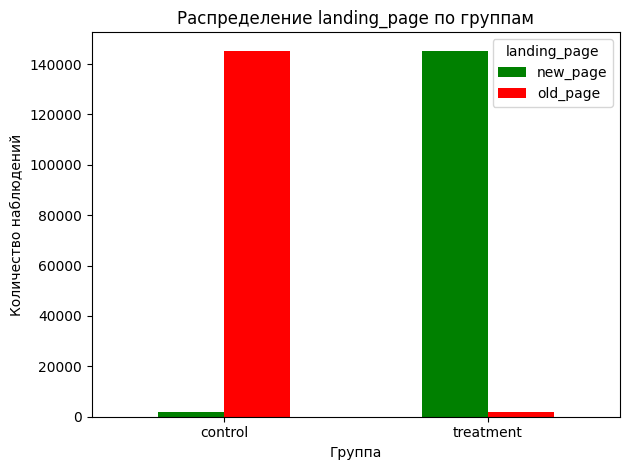

In [ ]:
ct.plot(kind='bar', color=['green', 'red'])

plt.xlabel('Группа')
plt.ylabel('Количество наблюдений')
plt.title('Распределение landing_page по группам')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

3893 (1928+1965) пользователя, которые попали не в ту задуманную группу.

Это ошибочные данные, так как "По замыслу A/B-теста контрольной группе должна была показываться старая версия лендинга; экспериментальной группе должна была показываться новая версия лендинга". Удаляем их.

In [ ]:
df=df[((df['group'] == 'control') & (df['landing_page'] == 'old_page')) |
    ((df['group'] == 'treatment') & (df['landing_page'] == 'new_page'))]
df

,user_id,timestamp,group,landing_page,converted
0,851104,2025-01-21 22:11:48.556739,control,old_page,0
1,804228,2025-01-12 08:01:45.159739,control,old_page,0
2,661590,2025-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2025-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2025-01-21 01:52:26.210827,control,old_page,1
...,...,...,...,...,...
294473,751197,2025-01-03 22:28:38.630509,control,old_page,0
294474,945152,2025-01-12 00:51:57.078372,control,old_page,0
294475,734608,2025-01-22 11:45:03.439544,control,old_page,0
294476,697314,2025-01-15 01:20:28.957438,control,old_page,0


In [ ]:
df['user_id'].nunique()

290584

290584 из 290585, следовательно, только один пользователь вошел в обе группы или вобще просто продублирован в одной. Удаляем его

In [ ]:
df=df.drop_duplicates(subset='user_id')

Переменные group и landing_page теперь дублируют друг друга, удаляем group.

In [ ]:
del df["group"]

## Проверка коректности распределения

Разделяем timestamp на date и time.

In [ ]:
df['timestamp']=pd.to_datetime(df['timestamp'])
df["date"]=df['timestamp'].dt.date
df['time']=df['timestamp'].dt.time
df["hour"]=df['timestamp'].dt.hour

/tmp/ipython-input-3408404838.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['timestamp']=pd.to_datetime(df['timestamp'])
/tmp/ipython-input-3408404838.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["date"]=df['timestamp'].dt.date
/tmp/ipython-input-3408404838.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Добавляем столбец день недели как дополнительный параметр.

In [ ]:
df["weekday"] = pd.to_datetime(df["date"]).dt.day_name()

/tmp/ipython-input-2750796407.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["weekday"] = pd.to_datetime(df["date"]).dt.day_name()


In [ ]:
del df['timestamp']

In [ ]:
df

,user_id,landing_page,converted,date,time,hour,weekday
0,851104,old_page,0,2025-01-21,22:11:48.556739,22,Tuesday
1,804228,old_page,0,2025-01-12,08:01:45.159739,8,Sunday
2,661590,new_page,0,2025-01-11,16:55:06.154213,16,Saturday
3,853541,new_page,0,2025-01-08,18:28:03.143765,18,Wednesday
4,864975,old_page,1,2025-01-21,01:52:26.210827,1,Tuesday
...,...,...,...,...,...,...,...
294473,751197,old_page,0,2025-01-03,22:28:38.630509,22,Friday
294474,945152,old_page,0,2025-01-12,00:51:57.078372,0,Sunday
294475,734608,old_page,0,2025-01-22,11:45:03.439544,11,Wednesday
294476,697314,old_page,0,2025-01-15,01:20:28.957438,1,Wednesday


In [ ]:
daily = df.groupby('date')['converted'].agg(['sum','count', 'mean'])
daily.columns = ['register','count','proportion']
print(daily)

            register  count  proportion
date                                   
2025-01-02       701   5712    0.122724
2025-01-03      1503  13208    0.113795
2025-01-04      1565  13119    0.119293
2025-01-05      1540  12932    0.119084
2025-01-06      1595  13353    0.119449
2025-01-07      1567  13213    0.118595
2025-01-08      1604  13387    0.119818
2025-01-09      1574  13243    0.118855
2025-01-10      1597  13350    0.119625
2025-01-11      1563  13361    0.116982
2025-01-12      1608  13159    0.122198
2025-01-13      1490  13060    0.114089
2025-01-14      1617  13147    0.122994
2025-01-15      1552  13263    0.117017
2025-01-16      1583  13136    0.120509
2025-01-17      1645  13155    0.125048
2025-01-18      1633  13085    0.124799
2025-01-19      1557  13130    0.118583
2025-01-20      1539  13213    0.116476
2025-01-21      1609  13309    0.120896
2025-01-22      1573  13265    0.118583
2025-01-23      1647  13349    0.123380
2025-01-24       891   7435    0.119839


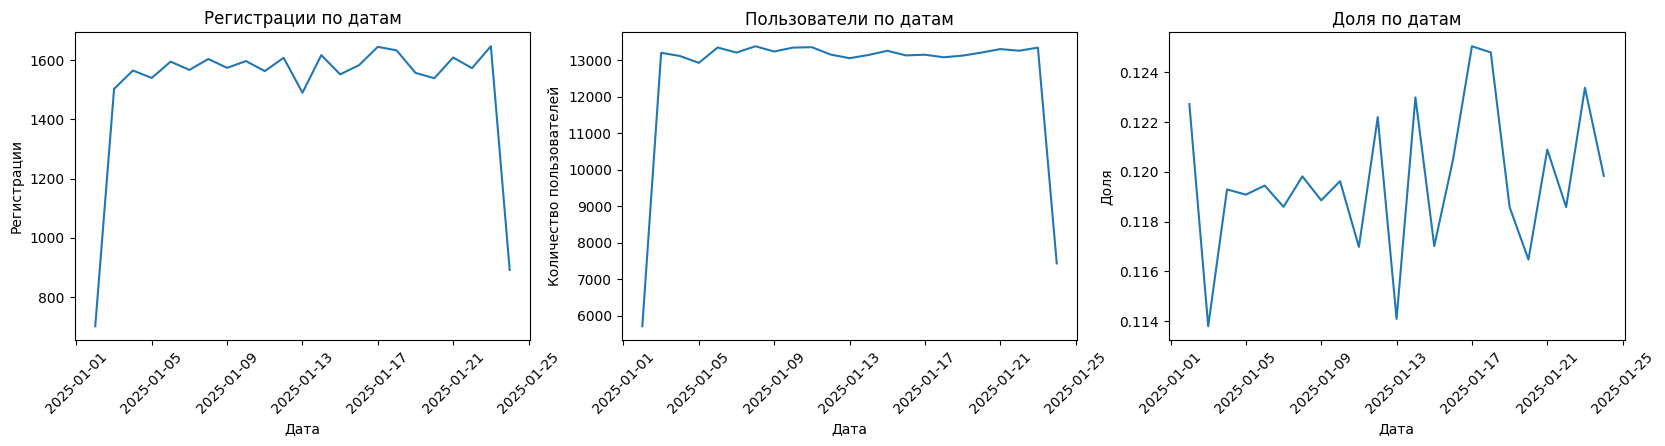

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 4))

axes[0].plot(daily.index, daily['register'])
axes[0].set_xlabel('Дата')
axes[0].set_ylabel('Регистрации')
axes[0].set_title('Регистрации по датам')
axes[0].tick_params(axis='x', rotation=45)

axes[1].plot(daily.index, daily['count'])
axes[1].set_xlabel('Дата')
axes[1].set_ylabel('Количество пользователей')
axes[1].set_title('Пользователи по датам')
axes[1].tick_params(axis='x', rotation=45)

axes[2].plot(daily.index, daily['proportion'])
axes[2].set_xlabel('Дата')
axes[2].set_ylabel('Доля')
axes[2].set_title('Доля по датам')
axes[2].tick_params(axis='x', rotation=45)

plt.show()

Выделяются 2025-01-02 и 2025-01-24 - в них в два раза меньше пользователей, чем в другие дни. Теоретически из-за них могут "съезжать" значения, так что на всякий случай удалим их.

/tmp/ipython-input-2835599279.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'])


            register  count  proportion
date                                   
2025-01-03      1503  13208    0.113795
2025-01-04      1565  13119    0.119293
2025-01-05      1540  12932    0.119084
2025-01-06      1595  13353    0.119449
2025-01-07      1567  13213    0.118595
2025-01-08      1604  13387    0.119818
2025-01-09      1574  13243    0.118855
2025-01-10      1597  13350    0.119625
2025-01-11      1563  13361    0.116982
2025-01-12      1608  13159    0.122198
2025-01-13      1490  13060    0.114089
2025-01-14      1617  13147    0.122994
2025-01-15      1552  13263    0.117017
2025-01-16      1583  13136    0.120509
2025-01-17      1645  13155    0.125048
2025-01-18      1633  13085    0.124799
2025-01-19      1557  13130    0.118583
2025-01-20      1539  13213    0.116476
2025-01-21      1609  13309    0.120896
2025-01-22      1573  13265    0.118583
2025-01-23      1647  13349    0.123380


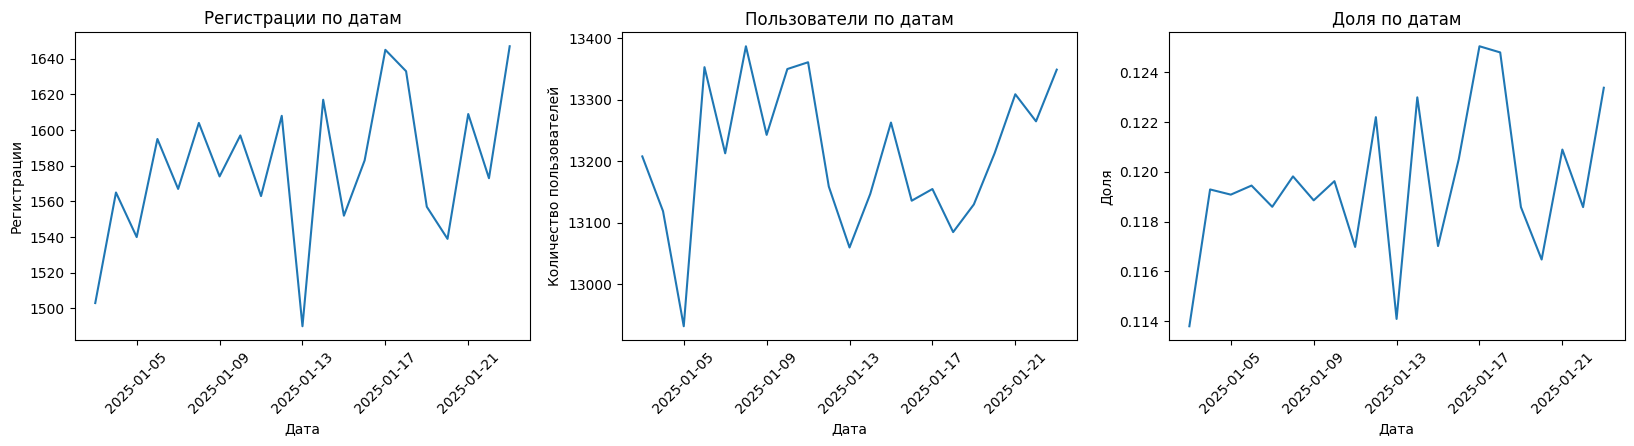

In [ ]:
df['date'] = pd.to_datetime(df['date'])
df = df[(df["date"] != "2025-01-02") & (df["date"] != "2025-01-24")]

daily = df.groupby('date')['converted'].agg(['sum','count', 'mean'])
daily.columns = ['register','count','proportion']
print(daily)

fig, axes = plt.subplots(1, 3, figsize=(20, 4))

axes[0].plot(daily.index, daily['register'])
axes[0].set_xlabel('Дата')
axes[0].set_ylabel('Регистрации')
axes[0].set_title('Регистрации по датам')
axes[0].tick_params(axis='x', rotation=45)

axes[1].plot(daily.index, daily['count'])
axes[1].set_xlabel('Дата')
axes[1].set_ylabel('Количество пользователей')
axes[1].set_title('Пользователи по датам')
axes[1].tick_params(axis='x', rotation=45)

axes[2].plot(daily.index, daily['proportion'])
axes[2].set_xlabel('Дата')
axes[2].set_ylabel('Доля')
axes[2].set_title('Доля по датам')
axes[2].tick_params(axis='x', rotation=45)

plt.show()

In [ ]:
df

,user_id,landing_page,converted,date,time,hour,weekday
0,851104,old_page,0,2025-01-21,22:11:48.556739,22,Tuesday
1,804228,old_page,0,2025-01-12,08:01:45.159739,8,Sunday
2,661590,new_page,0,2025-01-11,16:55:06.154213,16,Saturday
3,853541,new_page,0,2025-01-08,18:28:03.143765,18,Wednesday
4,864975,old_page,1,2025-01-21,01:52:26.210827,1,Tuesday
...,...,...,...,...,...,...,...
294473,751197,old_page,0,2025-01-03,22:28:38.630509,22,Friday
294474,945152,old_page,0,2025-01-12,00:51:57.078372,0,Sunday
294475,734608,old_page,0,2025-01-22,11:45:03.439544,11,Wednesday
294476,697314,old_page,0,2025-01-15,01:20:28.957438,1,Wednesday


Посмотрим, равномерно ли разбиты пользователи по группам. Для этого используем биномиальный тест с теоретической вероятностью успеха 0.05, где вероятность успеха - попадание в первую группу.

Нулевая гипотеза - разбиение на группы тестирования равномерно

Альтернативная гипотеза - разбиение на группы тестирования неравномерно

In [ ]:
res = binomtest(len(df[df["landing_page"] == "old_page"]), len(df) , p=0.5)
print(res)

BinomTestResult(k=138661, n=277437, alternative='two-sided', statistic=0.4997927457404744, pvalue=0.8286506114623643)


В результате p-value > 0.05, не отвергаем нулевую гипотезу.

Проверим однородность групп - посмотрим на зависимости между категориальными временными переменными и группами. Так как данные категориальные, запускаем хи-квадрат.

Нулевая гипотеза - разбиение на группы тестирования не зависит от "переменная".

Альтернативная гипотеза - разбиение на группы тестирования зависит от "переменная".

In [ ]:
cross_date = pd.crosstab(df['date'], df['landing_page'])
print(stats.chi2_contingency(cross_date))

Chi2ContingencyResult(statistic=np.float64(12.654349821381532), pvalue=np.float64(0.8917170444211452), dof=20, expected_freq=array([[6606.73741426, 6601.26258574],
       [6562.21896863, 6556.78103137],
       [6468.68021208, 6463.31978792],
       [6679.26746613, 6673.73253387],
       [6609.23845053, 6603.76154947],
       [6696.27451277, 6690.72548723],
       [6624.24466816, 6618.75533184],
       [6677.76684436, 6672.23315564],
       [6683.26912416, 6677.73087584],
       [6582.2272588 , 6576.7727412 ],
       [6532.70674063, 6527.29325937],
       [6576.22477175, 6570.77522825],
       [6634.24881324, 6628.75118676],
       [6570.72249195, 6565.27750805],
       [6580.22642978, 6574.77357022],
       [6545.21192199, 6539.78807801],
       [6567.72124843, 6562.27875157],
       [6609.23845053, 6603.76154947],
       [6657.25834694, 6651.74165306],
       [6635.24922775, 6629.75077225],
       [6677.26663711, 6671.73336289]]))


In [ ]:
cross_time = pd.crosstab(df['time'], df['landing_page'])
print(stats.chi2_contingency(cross_time))

Chi2ContingencyResult(statistic=np.float64(277436.9999999999), pvalue=np.float64(0.4991073900719673), dof=277436, expected_freq=array([[0.50020725, 0.49979275],
       [0.50020725, 0.49979275],
       [0.50020725, 0.49979275],
       ...,
       [0.50020725, 0.49979275],
       [0.50020725, 0.49979275],
       [0.50020725, 0.49979275]]))


In [ ]:
cross_hour = pd.crosstab(df['hour'], df['landing_page'])
print(stats.chi2_contingency(cross_hour))

Chi2ContingencyResult(statistic=np.float64(37.63269145186415), pvalue=np.float64(0.027879959854490217), dof=23, expected_freq=array([[5688.35689544, 5683.64310456],
       [5848.4232168 , 5843.5767832 ],
       [5773.89233592, 5769.10766408],
       [5782.89606649, 5778.10393351],
       [5737.37720636, 5732.62279364],
       [5849.42363131, 5844.57636869],
       [5743.87990066, 5739.12009934],
       [5816.91015978, 5812.08984022],
       [5805.90560019, 5801.09439981],
       [5710.86622188, 5706.13377812],
       [5787.39793178, 5782.60206822],
       [5813.90891626, 5809.09108374],
       [5793.40041883, 5788.59958117],
       [5743.87990066, 5739.12009934],
       [5839.41948623, 5834.58051377],
       [5689.8575172 , 5685.1424828 ],
       [5864.42984894, 5859.57015106],
       [5835.91803545, 5831.08196455],
       [5797.90228412, 5793.09771588],
       [5780.39503022, 5775.60496978],
       [5753.38383849, 5748.61616151],
       [5740.37844988, 5735.62155012],
       [5813.408

In [ ]:
cross_weekday = pd.crosstab(df['weekday'], df['landing_page'])
print(stats.chi2_contingency(cross_weekday))

Chi2ContingencyResult(statistic=np.float64(3.3735206049732285), pvalue=np.float64(0.7607140414885892), dof=6, expected_freq=array([[19864.73068841, 19848.26931159],
       [19821.21265729, 19804.78734271],
       [19790.70001478, 19774.29998522],
       [19618.62871931, 19602.37128069],
       [19872.23379722, 19855.76620278],
       [19842.72156922, 19826.27843078],
       [19965.77255377, 19949.22744623]]))


В случаях с date, time и weekday p-value > 0.05, то есть мы не отвергаем нулевую гипотезу. В случае с hour же p-value < 0.05, из-за чего мы отвергаем нулевую гипотезу, и у нас есть основания полагать, что разбиение на группы тестирования зависело от часа захода на платформу пользователя.

Так как эти данные нам предоставлены как уже проделанное тестирование, менять разбиение мы не можем, поэтому будем исходить из того, что разделение на группы было всё же проделано правильно. Однако запомним данную особенность с разбиением по часам.

### AA-тест

В представленном датасете нет исторических данных, а значит, AA-тестирование проводить не можем, так как ИД - обязательное условие для данного тестирования.

## Аналитика

Посмотрим как по времени распределены пользователи и конверсии (аналогичный график мы смотрели в предыдущем пункте)

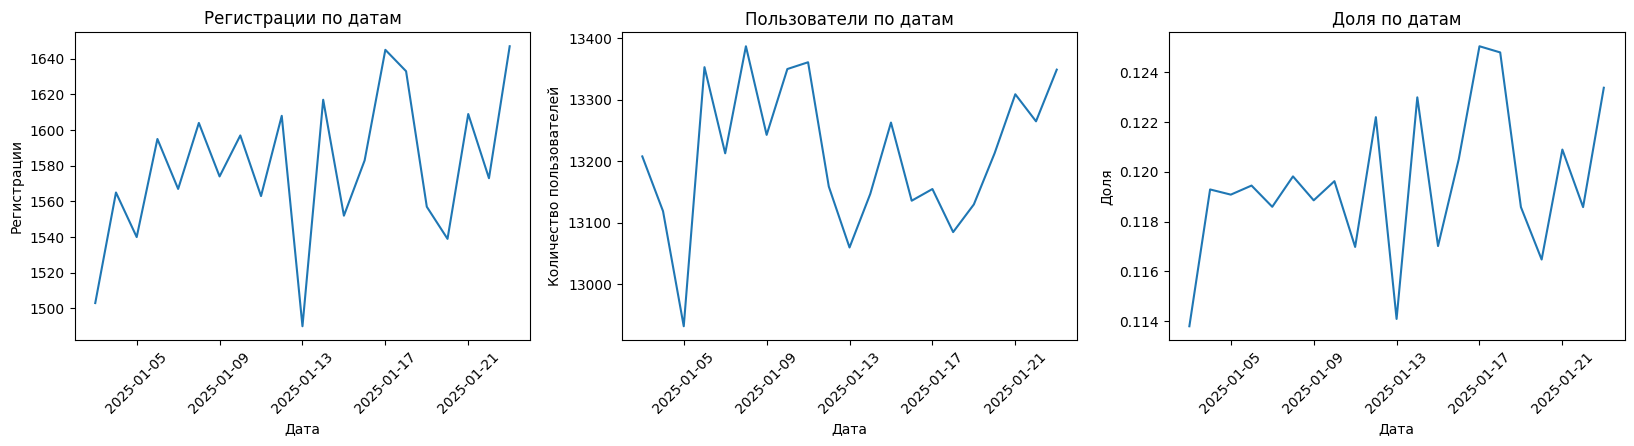

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 4))

axes[0].plot(daily.index, daily['register'])
axes[0].set_xlabel('Дата')
axes[0].set_ylabel('Регистрации')
axes[0].set_title('Регистрации по датам')
axes[0].tick_params(axis='x', rotation=45)

axes[1].plot(daily.index, daily['count'])
axes[1].set_xlabel('Дата')
axes[1].set_ylabel('Количество пользователей')
axes[1].set_title('Пользователи по датам')
axes[1].tick_params(axis='x', rotation=45)

axes[2].plot(daily.index, daily['proportion'])
axes[2].set_xlabel('Дата')
axes[2].set_ylabel('Доля')
axes[2].set_title('Доля по датам')
axes[2].tick_params(axis='x', rotation=45)

plt.show()

Тут мы посмотрели как по дням распределены пользователи и какая часть из них по дням совершила регистрацию (суммируются 1 и делятся на общее количество). Все доли распределены равномерно в диапозоне 0.114–0.125. Тут вряд ли удастся выявить зависимость.

Итого мы рассматриваем 21 день.

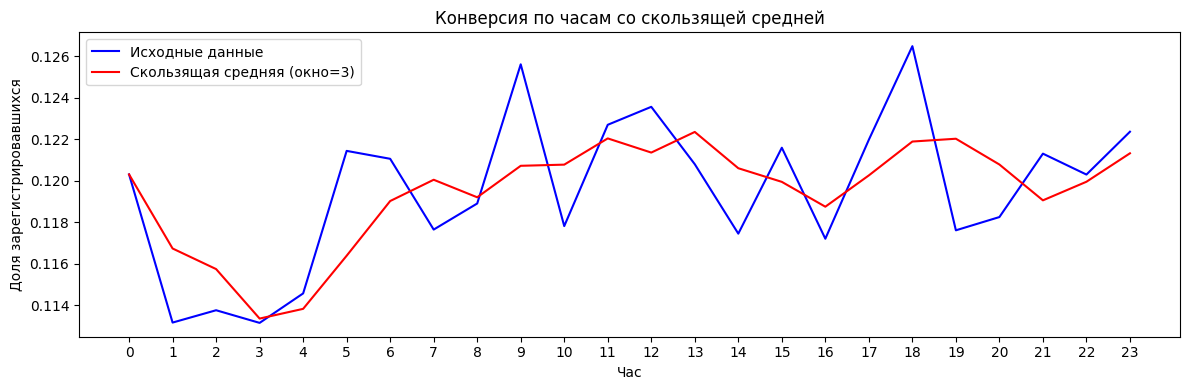

hour
0     1368
1     1323
2     1313
3     1308
4     1314
5     1420
6     1390
7     1368
8     1380
9     1434
10    1363
11    1426
12    1431
13    1387
14    1371
15    1383
16    1374
17    1423
18    1466
19    1359
20    1360
21    1392
22    1398
23    1410
Name: converted, dtype: int64


In [ ]:
hourly = df.groupby('hour')['converted'].mean()

window_size = 3
hourly_sma = hourly.rolling(window=window_size, min_periods=1).mean()

plt.figure(figsize=(12, 4))

plt.plot(hourly.index, hourly.values, label='Исходные данные', color='blue')

plt.plot(hourly_sma.index, hourly_sma.values, label=f'Скользящая средняя (окно={window_size})', color='red')

plt.xticks(range(24))
plt.xlabel('Час')
plt.ylabel('Доля зарегистрировавшихся')
plt.title('Конверсия по часам со скользящей средней')
plt.legend()
plt.tight_layout()
plt.show()

hourly = df.groupby('hour')['converted'].sum()
print(hourly)

Здесь можно выделить упадок конверсии в акцентированно "ночные" часы с 1 до 4. Заметим, что пользователи распределены по часам достаточно равномерно, так что мы можем утверждать, что подобные "упадки" конверсии не связаны с маленькой выборкой.

/tmp/ipython-input-1341322741.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["weekday"] = pd.Categorical(df["weekday"], categories=order, ordered=True)
/tmp/ipython-input-1341322741.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  weekdaily = df.groupby('weekday')['converted'].mean()


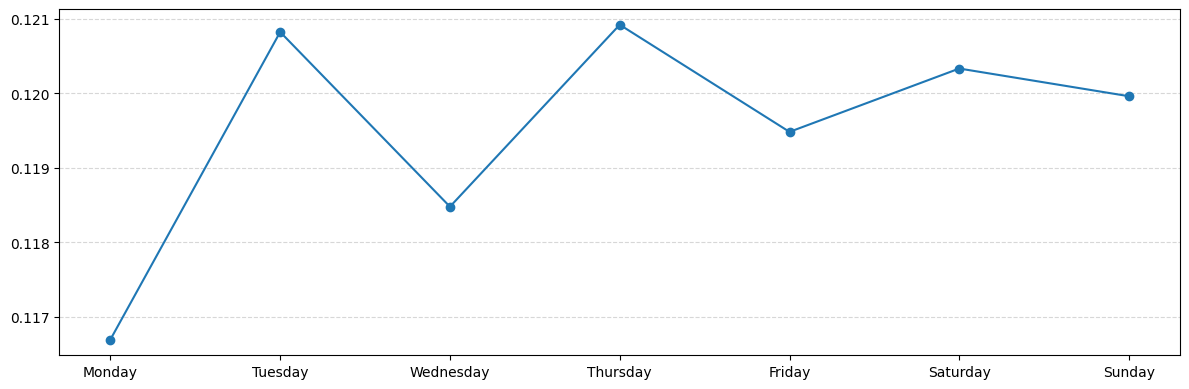

In [ ]:
order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

df["weekday"] = pd.Categorical(df["weekday"], categories=order, ordered=True)

weekdaily = df.groupby('weekday')['converted'].mean()

plt.figure(figsize=(12,4))

plt.plot(weekdaily.index, weekdaily.values, marker='o')

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Явно выделяется понедельник как самый неуспешный - если в остальные дни доля колеблется от 0.1185 до 0.121, в среднем равняясь примерно 0.12, то в понедельник доля опускается ниже 0.117

## Анализ тестирования

Теоретически для проверки разницы между значениями конверсии в двух группах подходит Z-тест для двух долей: метрика бинарная, наблюдения независимы, выборки сбалансированы по времени, нет дублирований. Однако нужно проверить, достаточно ли большая у нас выборка для проведения Z-теста для двух долей.

In [ ]:
summary = df.groupby('landing_page')['converted'].agg(['count', 'mean'])
summary['success'] = summary['count'] * summary['mean']
summary['failure'] = summary['count'] * (1 - summary['mean'])
summary

,count,mean,success,failure
landing_page,,,,
new_page,138776,0.118709,16474.0,122302.0
old_page,138661,0.120344,16687.0,121974.0


По условию применимости теста n * p ≥ 5 и n * (1−p) ≥ 5. Наши значения сильно больше, значит, Z-тест для двух долей применим.

Нулевая гипотеза: между конверсиями двух версий нет различий

Альтернативная гипотеза: конверсии двух версий различаются

In [ ]:
from statsmodels.stats.proportion import proportions_ztest

successes = summary['success'].values
nobs = summary['count'].values

print(proportions_ztest(count=successes, nobs=nobs, alternative='two-sided'))

(np.float64(-1.3269871802998114), np.float64(0.1845129233966314))


После проведения теста нельзя отвергнуть нулевую гипотезу, так как p-value = 0.18 > 0.05. Между конверсиями двух версий нет различий.

### Bootstrap

Для корректного сохранения структуры тестирования при проведении bootstrap разобьем датасет на группы старого и нового лендинга.

In [ ]:
old_page = df[df["landing_page"] == "old_page"]
new_page = df[df["landing_page"] == "new_page"]

Получим список дней недели, так как будем делать стратификацию - на основе проведенного выше анализа можем понять, что по дням есть неравномерность распределения.

Так как датасет большой, будем стараться делать оптимизированный алгоритм, поэтому с самого начала заранее составим слои, по которым будем двигаться. В результате получим 2 списка, в котором ключи - дни недели, а значения - все значения конверсий для этих дней.

In [ ]:
weekdays = sorted(df["weekday"].unique())
old_by_w = {w: old_page[old_page["weekday"] == w]["converted"].values for w in weekdays}
new_by_w = {w: new_page[new_page["weekday"] == w]["converted"].values for w in weekdays}
print(old_by_w)
print(new_by_w)

{'Friday': array([0, 0, 0, ..., 0, 0, 0]), 'Monday': array([0, 0, 0, ..., 0, 0, 0]), 'Saturday': array([0, 1, 0, ..., 0, 0, 0]), 'Sunday': array([0, 0, 0, ..., 0, 0, 0]), 'Thursday': array([0, 0, 0, ..., 0, 0, 0]), 'Tuesday': array([0, 1, 0, ..., 0, 0, 0]), 'Wednesday': array([1, 0, 1, ..., 0, 0, 0])}
{'Friday': array([0, 0, 0, ..., 0, 0, 0]), 'Monday': array([0, 0, 0, ..., 0, 0, 0]), 'Saturday': array([0, 1, 0, ..., 0, 0, 0]), 'Sunday': array([1, 0, 1, ..., 0, 0, 0]), 'Thursday': array([0, 0, 0, ..., 0, 0, 0]), 'Tuesday': array([0, 0, 0, ..., 0, 0, 0]), 'Wednesday': array([0, 1, 0, ..., 0, 0, 0])}


Посчитаем размеры каждого из слоев.

In [ ]:
n_old_w = {w: len(old_by_w[w]) for w in weekdays}
n_new_w = {w: len(new_by_w[w]) for w in weekdays}
print(n_old_w)
print(n_new_w)

{'Friday': 19861, 'Monday': 19692, 'Saturday': 19748, 'Sunday': 19527, 'Thursday': 19935, 'Tuesday': 19901, 'Wednesday': 19997}
{'Friday': 19852, 'Monday': 19934, 'Saturday': 19817, 'Sunday': 19694, 'Thursday': 19793, 'Tuesday': 19768, 'Wednesday': 19918}


А также доли трафика каждого слоя.

In [ ]:
total_n = sum(n_old_w[w] + n_new_w[w] for w in weekdays)
pi_w = {w: (n_old_w[w] + n_new_w[w]) / total_n for w in weekdays}
print(total_n)
print(pi_w)

277437
{'Friday': 0.14314240710503645, 'Monday': 0.1428288223993195, 'Saturday': 0.14260895266312712, 'Sunday': 0.1413690315278784, 'Thursday': 0.14319647343360836, 'Tuesday': 0.14298381254122558, 'Wednesday': 0.1438705003298046}


Зададим количество операций - 2000. Это достаточное количество для нашего размера датасета, увеличение значения не даст значительной разницы в точности.

Нулевая гипотеза: между конверсиями двух версий нет различий

Альтернативная гипотеза: конверсии двух версий различаются

In [ ]:
boot_operations = 2000

In [ ]:
for i in range(boot_operations):
    p_old = 0
    p_new = 0

    for w in weekdays:
        old_sample = np.random.choice(old_by_w[w], size=n_old_w[w], replace=True)
        p_old += pi_w[w] * old_sample.mean()

        new_sample = np.random.choice(new_by_w[w], size=n_new_w[w], replace=True)
        p_new += pi_w[w] * new_sample.mean()

In [ ]:
from scipy.stats import mannwhitneyu

print(mannwhitneyu(p_new, p_old, alternative='two-sided'))

MannwhitneyuResult(statistic=np.float64(0.0), pvalue=np.float64(1.0))


В результате получаем p-value = 0.9045 > 0.05. Это о том, что у нас нет оснований отвергать нулевую гипотезу. Значит, считаем, что между конверсиями двух версий нет различий.

### Анализ чувствительности

Шум будет двух видов - Flip и Drop. Flip - переворачиваем бинарные значения с какой-то вероятностью, Drop - выкидываем часть строк, иммитируя, что они не дошли до нас.


In [ ]:
epsilons = [0.005, 0.01, 0.02, 0.05]
results = []

In [ ]:
control = df[df['landing_page'] == 'old_page'].copy()
treatment = df[df['landing_page'] == 'new_page'].copy()

In [ ]:
cr_c_base = control['converted'].mean()
cr_t_base = treatment['converted'].mean()
uplift_base = cr_t_base - cr_c_base
successes_base = [treatment['converted'].sum(), control['converted'].sum()]
nobs_base = [len(treatment), len(control)]

print(proportions_ztest(successes_base, nobs_base, alternative='two-sided'))

(np.float64(-1.3269871802998114), np.float64(0.1845129233966314))


In [ ]:
for eps in epsilons:
    control_flip = control['converted'].copy()
    treatment_flip = treatment['converted'].copy()

    mask_c = np.random.rand(len(control_flip)) < eps
    mask_t = np.random.rand(len(treatment_flip)) < eps

    control_flip.loc[mask_c] = 1 - control_flip.loc[mask_c]
    treatment_flip.loc[mask_t] = 1 - treatment_flip.loc[mask_t]

    cr_c = control_flip.mean()
    cr_t = treatment_flip.mean()
    uplift = cr_t - cr_c

    successes = [treatment_flip.sum(), control_flip.sum()]
    nobs = [len(treatment_flip), len(control_flip)]
    stat, p = proportions_ztest(successes, nobs, alternative='two-sided')

    results.append({
        'noise_type': 'flip',
        'eps': eps,
        'cr_control': cr_c,
        'cr_treatment': cr_t,
        'uplift': uplift,
        'p_value': p
    })

In [ ]:
sensitivity_df = pd.DataFrame(results)
sensitivity_df

,noise_type,eps,cr_control,cr_treatment,uplift,p_value
0,flip,0.005,0.124289,0.122564,-0.001724,0.167400
1,flip,0.010,0.127887,0.126420,-0.001468,0.245882
2,flip,0.020,0.135568,0.133719,-0.001849,0.153708
3,flip,0.050,0.157571,0.155913,-0.001658,0.229668


Drop-тест

In [ ]:
for eps in epsilons:
    mask_c_drop = np.random.rand(len(control)) > eps
    mask_t_drop = np.random.rand(len(treatment)) > eps

    control_drop = control[mask_c_drop].copy()
    treatment_drop = treatment[mask_t_drop].copy()

    cr_c = control_drop['converted'].mean()
    cr_t = treatment_drop['converted'].mean()
    uplift = cr_t - cr_c

    successes = [treatment_drop['converted'].sum(), control_drop['converted'].sum()]
    nobs = [len(treatment_drop), len(control_drop)]
    stat, p = proportions_ztest(successes, nobs, alternative='two-sided')

    results.append({
        'noise_type': 'drop',
        'eps': eps,
        'cr_control': cr_c,
        'cr_treatment': cr_t,
        'uplift': uplift,
        'p_value': p
    })

In [ ]:
sensitivity_df = pd.DataFrame(results)
sensitivity_df

,noise_type,eps,cr_control,cr_treatment,uplift,p_value
0,flip,0.005,0.124289,0.122564,-0.001724,0.167400
1,flip,0.010,0.127887,0.126420,-0.001468,0.245882
2,flip,0.020,0.135568,0.133719,-0.001849,0.153708
3,flip,0.050,0.157571,0.155913,-0.001658,0.229668
4,drop,0.005,0.120414,0.118719,-0.001695,0.170022
5,drop,0.010,0.120376,0.118643,-0.001732,0.161629
6,drop,0.020,0.120458,0.118904,-0.001554,0.212100
7,drop,0.050,0.120834,0.118647,-0.002187,0.083693


Проведем еще и Variance Inflation Noise Test. Мы моделируем ситуацию, когда вероятность конверсии не одинаковая у всех пользователей, а варьируется сильнее, чем предполагает биномиальное распределение.

In [ ]:
for eps in epsilons:
    control_vi = control['converted'].copy().astype(float)
    treatment_vi = treatment['converted'].copy().astype(float)

    noise_c = np.random.normal(0, eps, size=len(control_vi))
    noise_t = np.random.normal(0, eps, size=len(treatment_vi))

    control_prob = np.clip(control_vi + noise_c, 0, 1)
    treatment_prob = np.clip(treatment_vi + noise_t, 0, 1)

    control_new = np.random.binomial(1, control_prob)
    treatment_new = np.random.binomial(1, treatment_prob)

    cr_c = control_new.mean()
    cr_t = treatment_new.mean()
    uplift = cr_t - cr_c

    successes = [treatment_new.sum(), control_new.sum()]
    nobs = [len(treatment_new), len(control_new)]

    stat, p = proportions_ztest(successes, nobs, alternative='two-sided')

    results.append({
        'noise_type': 'variance_inflation',
        'eps': eps,
        'cr_control': cr_c,
        'cr_treatment': cr_t,
        'uplift': uplift,
        'p_value': p
    })

In [ ]:
sensitivity_df = pd.DataFrame(results)
sensitivity_df

,noise_type,eps,cr_control,cr_treatment,uplift,p_value
0,flip,0.005,0.124289,0.122564,-0.001724,0.167400
1,flip,0.010,0.127887,0.126420,-0.001468,0.245882
2,flip,0.020,0.135568,0.133719,-0.001849,0.153708
3,flip,0.050,0.157571,0.155913,-0.001658,0.229668
4,drop,0.005,0.120414,0.118719,-0.001695,0.170022
5,drop,0.010,0.120376,0.118643,-0.001732,0.161629
6,drop,0.020,0.120458,0.118904,-0.001554,0.212100
7,drop,0.050,0.120834,0.118647,-0.002187,0.083693
8,variance_inflation,0.005,0.121887,0.120143,-0.001744,0.159063
9,variance_inflation,0.010,0.123366,0.121577,-0.001788,0.150800


В результате применения различных методик анализа чувствительности не было выявлено случая, где p-value опускался бы ниже порога значимости (0.05). Это значит, что не было выявлено условий, при которых можно отклонить нулевую гипотезу и считать, что конверсии двух сайтов отличаются.

## Рекомендации и бизнес-инсайты

Основные:

1. Новая версия лендинга показывает те же результаты конверсии, что и старая. Этот вывод подтверждается не только тестом начальных выборок, но и при применении bootstrap и анализа чувствительности.
2. "Ночные" часы с 1 до 4 показывают худщие показатели конверсии даже с учётом схожих по размеру выборок.
3. Стоит обратить внимание на понедельник как потенциально менее успешный день.

Дополнительные:
1. Стоит рассмотреть вариант повторного разбиения пользователей на группы, так как была выявлена потенциальная зависимость разбиения от часа захода на платформу.